In [72]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
data = pd.read_csv('PYTORCH_NOTEBOOKS/Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

data.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [74]:
data.dropna(inplace=True)

In [75]:
len(data)

325

In [76]:
data.shape

(325, 1)

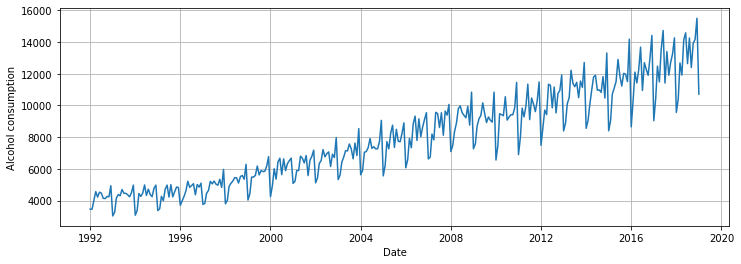

In [77]:
## plotting the data

plt.figure(figsize=(12,4))
plt.grid()
plt.plot(data['S4248SM144NCEN'])
plt.xlabel("Date")
plt.ylabel("Alcohol consumption")
plt.show()

## Prepare train and test data

In [78]:
y = data['S4248SM144NCEN'].values.astype(float)

test_size = 12 ### 12 is for the 12 months in a year

train_data = y[:-test_size]
test_data = y[-test_size:]

In [79]:
test_data

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [80]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
scaler = MinMaxScaler(feature_range=(-1,1))

train_norm = scaler.fit_transform(train_data.reshape(-1,1))

In [82]:
train_norm.min()

-1.0

In [83]:
train_norm.max()

1.0

In [84]:
train_norm.mean()

-0.2041940178388313

In [85]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM

In [86]:
train_norm = torch.FloatTensor(train_norm).view(-1)

window_size = 12

def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        
        out.append((window,label))
    return out

train_data = input_data(train_norm, window_size)
    

In [87]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [88]:
train_data[1]

(tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
         -0.7901, -0.7933, -0.6743, -1.0000]),
 tensor([-0.9607]))

## Define Model

In [89]:
class LSTMTSModel(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)
        
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size)) ## intialisation
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(x),-1))
        
        return pred[-1]

In [90]:
model = LSTMTSModel()
model

LSTMTSModel(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [91]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Train the model

In [92]:
epochs = 100

for epoch in range(epochs):   
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if epoch%10 == 0:
        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

Epoch: 0 Loss: 0.01289018
Epoch: 10 Loss: 0.00679644
Epoch: 20 Loss: 0.18631664
Epoch: 30 Loss: 0.35237628
Epoch: 40 Loss: 0.38022545
Epoch: 50 Loss: 0.38105014
Epoch: 60 Loss: 0.37891001
Epoch: 70 Loss: 0.37647125
Epoch: 80 Loss: 0.37400016
Epoch: 90 Loss: 0.37152395
